# Data Preparation for Machine Learning Modeling

This notebook prepares the cleaned employee dataset for machine learning modeling by creating:
- **X**: DataFrame with features ready for modeling (can be injected into sklearn's fit() method)
- **y**: Pandas Series containing the target variable
- **Reusable functions** for data transformations and feature engineering

## Objectives
- Load the cleaned merged dataset from EDA
- Define and validate the target variable
- Perform feature engineering and selection
- Handle categorical encoding (OneHotEncoder vs other methods)
- Analyze feature correlations (Pearson & Spearman)
- Create pairplots for non-linear correlation analysis
- Eliminate highly correlated features
- Generate final X and y ready for modeling

## Expected Outputs
- **X**: Feature matrix ready for sklearn modeling
- **y**: Target variable series
- **Transformation functions** for reproducible feature engineering
- **Correlation analysis** and feature selection recommendations

## 1. Import Required Libraries

In [204]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import spearmanr, pearsonr

# Machine Learning preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Utils functions
import os
import sys

# Add the src directory to Python path to import our utils module
src_path = os.path.abspath('../../src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Import feature engineering utilities from our custom module
from utils import ( # type: ignore
    identify_feature_types,
    create_correlation_matrix,
    apply_binary_encoding,
    apply_label_encoding,
    apply_onehot_encoding,
    apply_ordinal_encoding,
    remove_highly_correlated_features,
    validate_data_quality,
    print_feature_engineering_summary,
    DEFAULT_TARGET_VARIABLE,
    DEFAULT_CORRELATION_THRESHOLD
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ============================================================================
# CONFIGURATION: TARGET VARIABLE
# ============================================================================
TARGET_VARIABLE = 'a_quitte_l_entreprise'  # Employee turnover prediction (0=stayed, 1=left)

print("✅ Libraries imported successfully!")
print(f"🎯 Target variable set to: {TARGET_VARIABLE}")
print("📋 Feature engineering functions imported from utils:")
print("   - identify_feature_types()")
print("   - create_correlation_matrix()")
print("   - apply_binary_encoding()")
print("   - apply_label_encoding()")
print("   - apply_onehot_encoding()")
print("   - apply_ordinal_encoding()")
print("   - remove_highly_correlated_features()")
print("   - validate_data_quality()")
print("   - print_feature_engineering_summary()")

✅ Libraries imported successfully!
🎯 Target variable set to: a_quitte_l_entreprise
📋 Feature engineering functions imported from utils:
   - identify_feature_types()
   - create_correlation_matrix()
   - apply_binary_encoding()
   - apply_label_encoding()
   - apply_onehot_encoding()
   - apply_ordinal_encoding()
   - remove_highly_correlated_features()
   - validate_data_quality()
   - print_feature_engineering_summary()


## 2. Load the Cleaned Dataset

Load the merged and cleaned dataset from the EDA phase.

In [205]:
# Load the cleaned merged dataset
data_path = '../../data/processed/employee_data_merged_clean.csv'

try:
    df = pd.read_csv(data_path)
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"🔍 Columns: {len(df.columns)} features")
    
    # Display basic info
    print("\n" + "="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    print(df.info())
    
except FileNotFoundError:
    print(f"❌ File not found: {data_path}")
    print("Please ensure the EDA notebook has been run and the cleaned dataset exists.")

✅ Dataset loaded successfully!
📊 Dataset shape: (1470, 29)
🔍 Columns: 29 features

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   annee_experience_totale                    1470 non-null   int64 
 9   annees_

## 3. Feature Type Analysis

Analyze the dataset to identify different types of features automatically.

In [206]:
# Test if utils functions are available, if not provide a fallback
try:
    # Test if we can call a function from utils
    print("FEATURE TYPE ANALYSIS:")
    print("="*50)
    
    # Identify different types of features in the dataset
    feature_types = identify_feature_types(df, exclude_cols=[TARGET_VARIABLE])
    
    print("✅ Feature type analysis complete!")
    print(f"Feature type breakdown:")
    for feature_type, features in feature_types.items():
        print(f"  • {feature_type.replace('_', ' ').title()}: {len(features)} features")
        if features and len(features) <= 8:
            print(f"    - {', '.join(features)}")
        elif features:
            print(f"    - {', '.join(features[:5])} ... and {len(features)-5} more")
    
    # Print a summary using our utils function
    print_feature_engineering_summary(feature_types)
    
except NameError:
    print("⚠️ Utils functions not available. Please run the import cell first.")
    print("If the import fails, you may need to:")
    print("1. Check that src/utils.py exists")
    print("2. Restart the kernel and run cells in order")
    print("3. Use absolute import path")
    
    # Create a basic feature_types dictionary as fallback
    feature_types = {
        'numerical_continuous': [],
        'numerical_discrete': [],
        'categorical_ordinal': [],
        'categorical_nominal': [],
        'binary': [],
        'id_columns': []
    }
    
    # Manual feature type identification as fallback
    for col in df.columns:
        if col == TARGET_VARIABLE:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                feature_types['binary'].append(col)
            elif df[col].nunique() <= 10:
                feature_types['categorical_ordinal'].append(col)
            else:
                feature_types['numerical_continuous'].append(col)
        else:
            feature_types['categorical_nominal'].append(col)
    
    print("📋 Fallback feature type analysis:")
    for feature_type, features in feature_types.items():
        if features:
            print(f"  • {feature_type.replace('_', ' ').title()}: {len(features)} features")

FEATURE TYPE ANALYSIS:
✅ Feature type analysis complete!
Feature type breakdown:
  • Numerical Continuous: 5 features
    - age, revenu_mensuel, annee_experience_totale, annees_dans_l_entreprise, distance_domicile_travail
  • Numerical Discrete: 3 features
    - annees_dans_le_poste_actuel, annees_depuis_la_derniere_promotion, annes_sous_responsable_actuel
  • Categorical Ordinal: 10 features
    - nombre_experiences_precedentes, satisfaction_employee_environnement, note_evaluation_precedente, niveau_hierarchique_poste, satisfaction_employee_nature_travail ... and 5 more
  • Categorical Nominal: 6 features
    - statut_marital, departement, poste, augementation_salaire_precedente, domaine_etude, frequence_deplacement
  • Binary: 3 features
    - genre, note_evaluation_actuelle, heure_supplementaires
  • Id Columns: 1 features
    - id_employee
FEATURE ENGINEERING SUMMARY

📊 FEATURE TYPE ANALYSIS:
  • Numerical Continuous: 5 features
    - age, revenu_mensuel, annee_experience_totale, a

## 8. Feature Encoding and Preprocessing

Apply appropriate encoding methods for categorical features and prepare data for modeling.

In [207]:
# Identify categorical features for encoding
print(df.select_dtypes(exclude=['number', 'boolean']).columns.tolist())

['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'domaine_etude', 'frequence_deplacement']


In [208]:
# One-hot encoding for 'departement' column using our utils function
one_hot_encoding_features = ['departement', 'statut_marital', 'poste']

for feature in one_hot_encoding_features:
	df, encoding_info = apply_onehot_encoding(df, [feature])

df.head()
    

✅ One-hot encoded departement: 2 new columns (dtype: int64)
✅ One-hot encoded statut_marital: 2 new columns (dtype: int64)
✅ One-hot encoded poste: 8 new columns (dtype: int64)


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead
0,1,41,F,5993,8,8,6,4,2,3,2,4,1,1,3,Oui,11 %,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0
1,2,49,M,5130,1,10,10,7,3,2,2,2,4,3,4,Non,23 %,Non,1,3,8,1,Infra & Cloud,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0
2,4,37,M,2090,6,7,0,0,4,2,1,3,2,3,3,Oui,15 %,Oui,0,3,2,2,Autre,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,5,33,F,2909,1,8,8,7,4,3,1,3,3,3,3,Oui,11 %,Non,0,3,3,4,Infra & Cloud,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0
4,7,27,M,3468,9,6,2,2,1,3,1,2,4,3,3,Non,12 %,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0


In [209]:
# Binary encoding for 'genre' column
df["genre"].value_counts()
df, encoding_info = apply_binary_encoding(df, ['genre'], {'genre': {'M': 0, 'F': 1}})
df.head()

✅ Binary encoded genre: {'M': 0, 'F': 1}


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,Oui,11 %,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,Non,23 %,Non,1,3,8,1,Infra & Cloud,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,Oui,15 %,Oui,0,3,2,2,Autre,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,Oui,11 %,Non,0,3,3,4,Infra & Cloud,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,Non,12 %,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0


In [210]:
# Binary encoding for 'heure_supplementaires' column
df["heure_supplementaires"].value_counts()
df, encoding_info = apply_binary_encoding(df, ["heure_supplementaires"], {"heure_supplementaires": {"Non": 0, "Oui": 1}})
df.head()

✅ Binary encoded heure_supplementaires: {'Non': 0, 'Oui': 1}


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11 %,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23 %,Non,1,3,8,1,Infra & Cloud,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15 %,Oui,0,3,2,2,Autre,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11 %,Non,0,3,3,4,Infra & Cloud,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12 %,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0


In [211]:
# Binary encoding for 'a_quitte_l_entreprise' column
df[TARGET_VARIABLE].value_counts()
df, encoding_info = apply_binary_encoding(df, [TARGET_VARIABLE], {TARGET_VARIABLE: {"Non": 0, "Oui": 1}})
df.head()

✅ Binary encoded a_quitte_l_entreprise: {'Non': 0, 'Oui': 1}


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11 %,1,0,0,1,2,Infra & Cloud,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23 %,0,1,3,8,1,Infra & Cloud,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15 %,1,0,3,2,2,Autre,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11 %,0,0,3,3,4,Infra & Cloud,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12 %,0,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0


In [212]:
# Convert 'augementation_salaire_precedente' from percentage string to float
df["augementation_salaire_precedente"].value_counts()
df["augementation_salaire_precedente"] = df["augementation_salaire_precedente"].str.rstrip(" %").astype(float)
df.head()

,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11.0,1,0,0,1,2,Infra & Cloud,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23.0,0,1,3,8,1,Infra & Cloud,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15.0,1,0,3,2,2,Autre,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11.0,0,0,3,3,4,Infra & Cloud,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12.0,0,1,3,2,1,Transformation Digitale,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0


In [213]:
# One-hot encoding for 'domaine_etude' column
df["domaine_etude"].value_counts()
df, encoding_info = apply_onehot_encoding(
    df, ["domaine_etude"]
)
df.head()

✅ One-hot encoded domaine_etude: 5 new columns (dtype: int64)


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Marketing,domaine_etude_Ressources Humaines,domaine_etude_Transformation Digitale
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11.0,1,0,0,1,2,Occasionnel,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23.0,0,1,3,8,1,Frequent,1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15.0,1,0,3,2,2,Occasionnel,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11.0,0,0,3,3,4,Frequent,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12.0,0,1,3,2,1,Occasionnel,2,2,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [214]:
# Ordinal encoding for 'frequence_deplacement' column
df["frequence_deplacement"].value_counts()
df, encoding_info = apply_ordinal_encoding(df, ["frequence_deplacement"], {"frequence_deplacement": ["Aucun", "Occasionnel", "Frequent"]})
df.head()

✅ Ordinal encoded frequence_deplacement: 3 levels


,id_employee,age,genre,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,departement_Consulting,departement_Ressources Humaines,statut_marital_Divorcé(e),statut_marital_Marié(e),poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Marketing,domaine_etude_Ressources Humaines,domaine_etude_Transformation Digitale
0,1,41,1,5993,8,8,6,4,2,3,2,4,1,1,3,1,11.0,1,0,0,1,2,1,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,2,49,0,5130,1,10,10,7,3,2,2,2,4,3,4,0,23.0,0,1,3,8,1,2,1,7,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,4,37,0,2090,6,7,0,0,4,2,1,3,2,3,3,1,15.0,1,0,3,2,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,5,33,1,2909,1,8,8,7,4,3,1,3,3,3,3,1,11.0,0,0,3,3,4,2,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,7,27,0,3468,9,6,2,2,1,3,1,2,4,3,3,0,12.0,0,1,3,2,1,1,2,2,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


## 9. Feature Selection and Final Preprocessing

Remove highly correlated features and prepare final X and y for modeling.

In [215]:
# Prepare features and target
print("PREPARING FINAL FEATURES AND TARGET:")
print("="*50)


# Drop target and ID columns from features
y = df[TARGET_VARIABLE].copy()
X_temp = df.drop(columns=[TARGET_VARIABLE, "id_employee"])  


print(f"Features shape before correlation filtering: {X_temp.shape}")
print(f"Target shape: {y.shape}")
print(f"Target variable: {TARGET_VARIABLE}")

PREPARING FINAL FEATURES AND TARGET:
Features shape before correlation filtering: (1470, 40)
Target shape: (1470,)
Target variable: a_quitte_l_entreprise


## 5. Feature Correlation Analysis

Analyze correlations between the final encoded features (X only) to identify multicollinearity issues.

In [216]:
# Prepare features for correlation analysis (numerical features only)
print("FEATURE CORRELATION ANALYSIS ON FINAL X FEATURES:")
print("="*60)

# Get only numerical features from X for correlation analysis
numerical_cols_in_X = [col for col in X_temp.columns if pd.api.types.is_numeric_dtype(X_temp[col])]
print(f"Analyzing correlations for {len(numerical_cols_in_X)} numerical features:")

# Show feature breakdown
if len(numerical_cols_in_X) <= 15:
    for col in numerical_cols_in_X:
        print(f"  - {col}")
else:
    for col in numerical_cols_in_X[:10]:
        print(f"  - {col}")
    print(f"  ... and {len(numerical_cols_in_X) - 10} more features")

print(f"\nNote: Excluding target variable '{TARGET_VARIABLE}' from correlation analysis")
print(f"Features include encoded categorical variables (one-hot encoded columns)")

# Create subset for correlation analysis
X_numerical_for_corr = X_temp[numerical_cols_in_X].copy()
print(f"\nCorrelation analysis dataset shape: {X_numerical_for_corr.shape}")

FEATURE CORRELATION ANALYSIS ON FINAL X FEATURES:
Analyzing correlations for 40 numerical features:
  - age
  - genre
  - revenu_mensuel
  - nombre_experiences_precedentes
  - annee_experience_totale
  - annees_dans_l_entreprise
  - annees_dans_le_poste_actuel
  - satisfaction_employee_environnement
  - note_evaluation_precedente
  - niveau_hierarchique_poste
  ... and 30 more features

Note: Excluding target variable 'a_quitte_l_entreprise' from correlation analysis
Features include encoded categorical variables (one-hot encoded columns)

Correlation analysis dataset shape: (1470, 40)


SPEARMAN CORRELATION ANALYSIS (FINAL FEATURES):
Highly correlated feature pairs (|correlation| >= 0.7):Highly correlated feature pairs (|correlation| >= 0.7):
  - revenu_mensuel ↔ annee_experience_totale: 0.710
  - revenu_mensuel ↔ niveau_hierarchique_poste: 0.920
  - annee_experience_totale ↔ niveau_hierarchique_poste: 0.735
  - annees_dans_l_entreprise ↔ annees_dans_le_poste_actuel: 0.854
  - annees_dans_l_entreprise ↔ annes_sous_responsable_actuel: 0.843
  - annees_dans_le_poste_actuel ↔ annes_sous_responsable_actuel: 0.725
  - departement_Consulting ↔ poste_Cadre Commercial: -0.733
  - departement_Ressources Humaines ↔ poste_Ressources Humaines: 0.905

  - revenu_mensuel ↔ annee_experience_totale: 0.710
  - revenu_mensuel ↔ niveau_hierarchique_poste: 0.920
  - annee_experience_totale ↔ niveau_hierarchique_poste: 0.735
  - annees_dans_l_entreprise ↔ annees_dans_le_poste_actuel: 0.854
  - annees_dans_l_entreprise ↔ annes_sous_responsable_actuel: 0.843
  - annees_dans_le_poste_actuel 

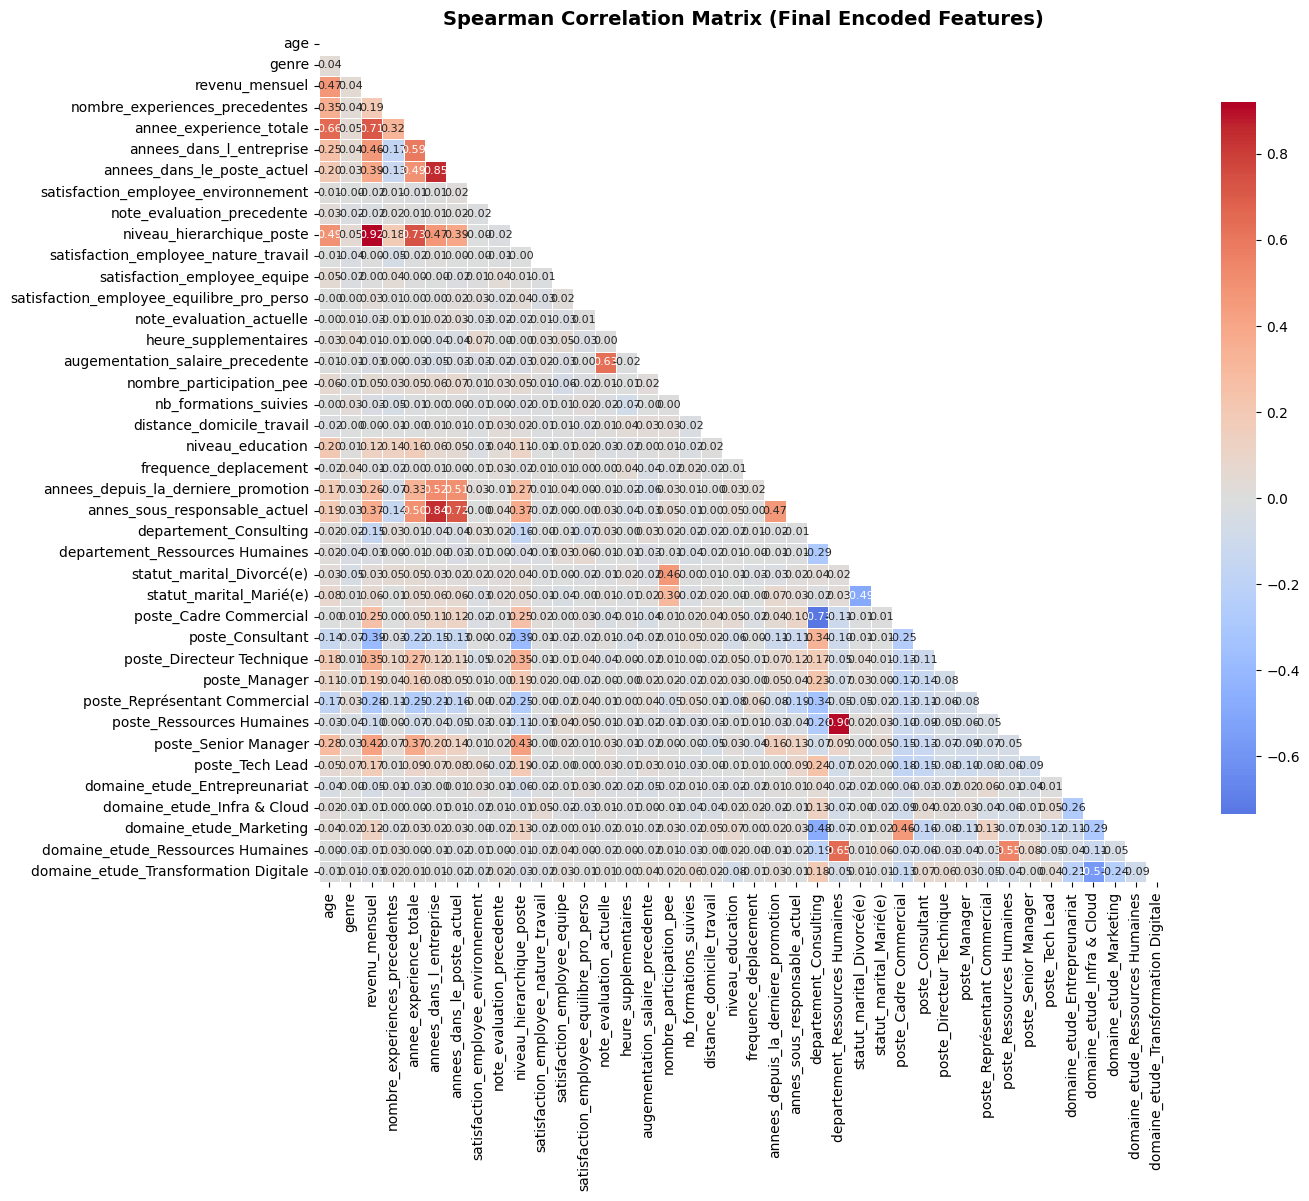


📊 Spearman correlation matrix shape: (40, 40)


In [217]:
# Spearman correlation analysis on final features
print("SPEARMAN CORRELATION ANALYSIS (FINAL FEATURES):")
print("="*50)

if len(numerical_cols_in_X) > 1:
    spearman_corr, spearman_high_corr = create_correlation_matrix(
        X_numerical_for_corr, method='spearman', threshold=0.7
    )

    print(f"Highly correlated feature pairs (|correlation| >= 0.7):")
    if spearman_high_corr:
        for pair in spearman_high_corr:
            print(f"  - {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print("  - No highly correlated pairs found")

    # Visualize Spearman correlation matrix
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
    sns.heatmap(spearman_corr, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                fmt='.2f', annot_kws={'size': 8})
    plt.title('Spearman Correlation Matrix (Final Encoded Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Spearman correlation matrix shape: {spearman_corr.shape}")
else:
    print("❌ Insufficient numerical features for Spearman correlation analysis")

PEARSON CORRELATION ANALYSIS (FINAL FEATURES):
Highly correlated feature pairs (|correlation| >= 0.7):
  - revenu_mensuel ↔ annee_experience_totale: 0.773
  - revenu_mensuel ↔ niveau_hierarchique_poste: 0.950
  - annee_experience_totale ↔ niveau_hierarchique_poste: 0.782
  - annees_dans_l_entreprise ↔ annees_dans_le_poste_actuel: 0.759
  - annees_dans_l_entreprise ↔ annes_sous_responsable_actuel: 0.769
  - annees_dans_le_poste_actuel ↔ annes_sous_responsable_actuel: 0.714
  - note_evaluation_actuelle ↔ augementation_salaire_precedente: 0.774
  - departement_Consulting ↔ poste_Cadre Commercial: -0.733
  - departement_Ressources Humaines ↔ poste_Ressources Humaines: 0.905


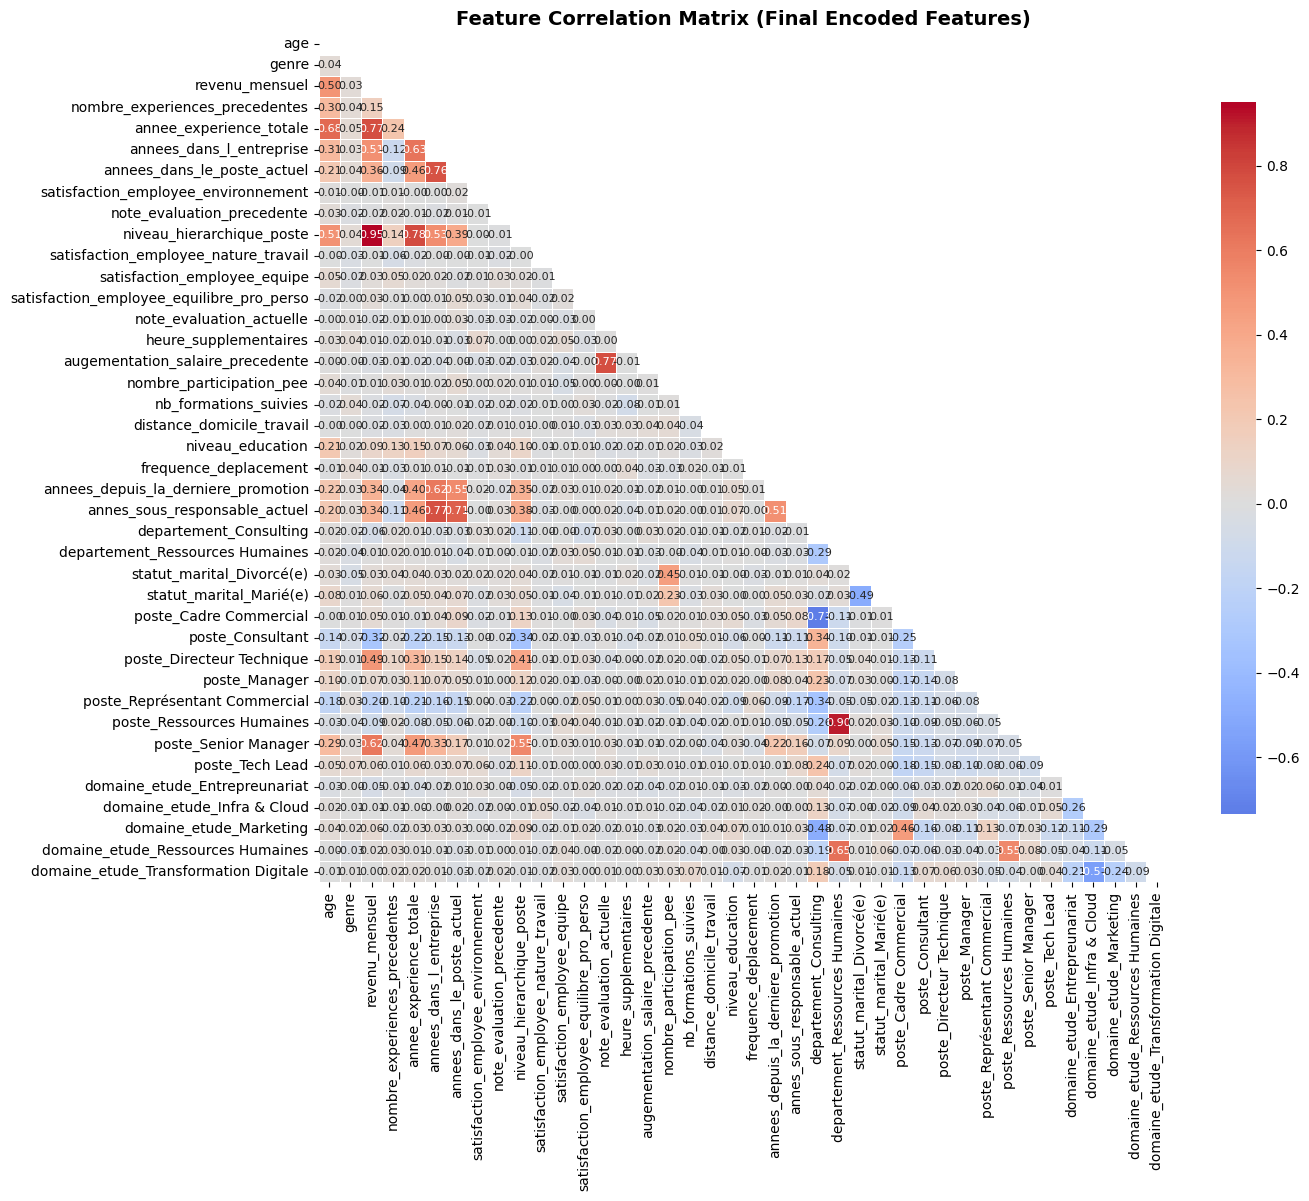


📊 Correlation matrix shape: (40, 40)


In [218]:
# Pearson correlation analysis on final features
print("PEARSON CORRELATION ANALYSIS (FINAL FEATURES):")
print("="*50)

if len(numerical_cols_in_X) > 1:
    pearson_corr, pearson_high_corr = create_correlation_matrix(
        X_numerical_for_corr, method='pearson', threshold=0.7
    )

    print(f"Highly correlated feature pairs (|correlation| >= 0.7):")
    if pearson_high_corr:
        for pair in pearson_high_corr:
            print(f"  - {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print("  - No highly correlated pairs found")

    # Visualize Pearson correlation matrix
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    sns.heatmap(pearson_corr, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                fmt='.2f', annot_kws={'size': 8})
    plt.title('Feature Correlation Matrix (Final Encoded Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Correlation matrix shape: {pearson_corr.shape}")
else:
    print("❌ Insufficient numerical features for correlation analysis")

In [219]:
# Feature correlation summary and recommendations
print("CORRELATION ANALYSIS SUMMARY:")
print("="*50)

if len(numerical_cols_in_X) > 1 and 'pearson_high_corr' in locals():
    total_features = len(numerical_cols_in_X)
    high_corr_pairs = len(pearson_high_corr)
    
    print(f"📊 Total features analyzed: {total_features}")
    print(f"🔗 High correlation pairs (≥0.7): {high_corr_pairs}")
    
    if high_corr_pairs > 0:
        print(f"\n⚠️  MULTICOLLINEARITY DETECTED:")
        print(f"   Found {high_corr_pairs} pairs of highly correlated features")
        print(f"   These may cause issues in linear models")
        print(f"   Consider removing one feature from each pair")
        
        # Show which features appear most frequently in correlations
        feature_counts = {}
        for pair in pearson_high_corr:
            feature_counts[pair['feature1']] = feature_counts.get(pair['feature1'], 0) + 1
            feature_counts[pair['feature2']] = feature_counts.get(pair['feature2'], 0) + 1
        
        if feature_counts:
            print(f"\n🎯 Features involved in multiple correlations:")
            sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
            for feature, count in sorted_features[:5]:  # Top 5
                print(f"   - {feature}: {count} correlation(s)")
    else:
        print(f"\n✅ NO MULTICOLLINEARITY ISSUES:")
        print(f"   All feature correlations are below 0.7 threshold")
        print(f"   Features are suitable for linear models")
        
    # Calculate max correlation
    max_corr = pearson_corr.abs().values
    max_corr = max_corr[max_corr < 1.0].max()  # Exclude self-correlations
    print(f"\n📈 Maximum absolute correlation: {max_corr:.3f}")
else:
    print("❌ Could not perform correlation analysis")

print(f"\n💡 Next step: Remove highly correlated features if needed")

CORRELATION ANALYSIS SUMMARY:
📊 Total features analyzed: 40
🔗 High correlation pairs (≥0.7): 9

⚠️  MULTICOLLINEARITY DETECTED:
   Found 9 pairs of highly correlated features
   These may cause issues in linear models
   Consider removing one feature from each pair

🎯 Features involved in multiple correlations:
   - revenu_mensuel: 2 correlation(s)
   - annee_experience_totale: 2 correlation(s)
   - niveau_hierarchique_poste: 2 correlation(s)
   - annees_dans_l_entreprise: 2 correlation(s)
   - annees_dans_le_poste_actuel: 2 correlation(s)

📈 Maximum absolute correlation: 0.950

💡 Next step: Remove highly correlated features if needed


In [220]:
# Remove highly correlated features
print("REMOVING HIGHLY CORRELATED FEATURES:")
print("="*50)

# Only apply to numerical features to avoid issues with one-hot encoded features
numerical_cols_in_X = [col for col in X_temp.columns if pd.api.types.is_numeric_dtype(X_temp[col])]
categorical_cols_in_X = [col for col in X_temp.columns if col not in numerical_cols_in_X]

print(f"Numerical columns in X: {len(numerical_cols_in_X)}")
print(f"Categorical/One-hot columns in X: {len(categorical_cols_in_X)}")

if len(numerical_cols_in_X) > 1:
    # Apply correlation filtering only to numerical features
    X_numerical = X_temp[numerical_cols_in_X]
    X_numerical_reduced, removed_features = remove_highly_correlated_features(
        X_numerical, correlation_threshold=0.9
    )
    
    # Combine back with categorical features
    if categorical_cols_in_X:
        X_categorical = X_temp[categorical_cols_in_X]
        X = pd.concat([X_numerical_reduced, X_categorical], axis=1)
    else:
        X = X_numerical_reduced
    
    print(f"Removed highly correlated features: {removed_features}")
    print(f"Final X shape: {X.shape}")
else:
    X = X_temp.copy()
    removed_features = []
    print("No correlation filtering applied (insufficient numerical features)")

print(f"\nFinal dataset dimensions:")
print(f"  - X (features): {X.shape}")
print(f"  - y (target): {y.shape}")

REMOVING HIGHLY CORRELATED FEATURES:
Numerical columns in X: 40
Categorical/One-hot columns in X: 0
Removed highly correlated features: ['niveau_hierarchique_poste', 'poste_Ressources Humaines']
Final X shape: (1470, 38)

Final dataset dimensions:
  - X (features): (1470, 38)
  - y (target): (1470,)
